# Demonstrate the equations behind the servo_with_limits dll

## Equation of motion of the harmonic oscillator

We start from a harmonic oscillator

$$
m \ddot{x} + c \dot{x} + k x = f
$$

By dividing by the mass we obtain

$$
\ddot{x} + \frac{c}{m} \dot{x} + \frac{k}{m} x = \frac{f}{m}
$$

We then introduce the frequency and damping

$$
\omega = \sqrt{k/m}
\qquad
\zeta = \frac{c}{2 \sqrt{k m}}
$$

so that

$$
k / m = \omega^2
\qquad
c / m = 2 \zeta \omega
$$

The equation of motion becomes

$$
\ddot{x} + 2 \zeta \omega \dot{x} + \omega^2 x = \frac{f}{m}
$$

## Reference displacement

To impose the reference displacement we set $f$ to

$$
f(t) = \omega^2 x_{\mathrm{ref}}(t)
$$

so that the equation of motion becomes

$$
\ddot{x} + 2 \zeta \omega \dot{x} + \omega^2 x = \omega^2 x_{\mathrm{ref}}
$$

$$
\ddot{x} + 2 \zeta \omega \dot{x} + \omega^2 x - \omega^2 x_{\mathrm{ref}} = 0
$$

$$
\ddot{x} + 2 \zeta \omega \dot{x} + \omega^2( x - x_{\mathrm{ref}}) = 0
$$

Next, we will simulate this system.

In [17]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import square
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

# Frequency and damping of the harmonic oscillator.
omega = 1.0 * 2*np.pi
xi = 0.2

# Time array.
time = np.linspace(0.0, 25.0, 1001)

# Reference displacement.
def x_reference(t):
    return square(2.0 * np.pi * 0.1 * t)

x_ref_all = x_reference(time)

# Initial condition.
x0 = np.array([1, 0])

def get_solution(acc_func,amax,vmax):
    def ode(t, x, omega, xi, x_ref_fun,amax,vmax):
        x_ref = x_ref_fun(t) # Evaluate reference displacement at current time.
    
        # Compute speed and acceleration.
        Dx = np.array([x[1],
                       acc_func(x,omega,xi,x_ref,amax,vmax)])
        return Dx
    
    return solve_ivp(ode, (time[0], time[-1]), x0, t_eval=time, args=(omega, xi, x_reference,amax,vmax))

def plot_solutions(acc_fun_lst, amax, vmax):
    fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,6))
    axes[0].plot(time, x_ref_all, label="Reference")
    
    for acc_fun in acc_fun_lst:
        sol = get_solution(acc_fun,amax,vmax)
        name = f'{acc_fun.__name__}({sol.nfev} iter)'
        
        # Compute acceleration.
        DDx = acc_fun(sol.y,omega,xi,x_ref_all,amax,vmax)
        
        axes[0].plot(sol.t, sol.y[0, :], label=name)
        axes[1].plot(sol.t, sol.y[1, :], label=name)
        axes[2].plot(time, DDx, label=name)
        
    for ax,n in zip(axes, ['Displacement','Speed','Acceleration']):
        ax.set_ylabel(n)
        ax.legend(loc=1) 
        ax.set_xlim([0,40])
    axes[2].set_xlabel("Time [s]")
    if vmax:
        axes[1].hlines([-vmax, +vmax], time[0], time[-1], colors='grey', linestyles='--')
    if amax:
        axes[2].hlines([-amax, +amax], time[0], time[-1], colors='grey', linestyles='--')
    plt.tight_layout()

The unconstrained acceleration is:
$$
\ddot{x} = - \omega^2( x - x_{\mathrm{ref}}) - 2 \zeta \omega \dot{x}
$$

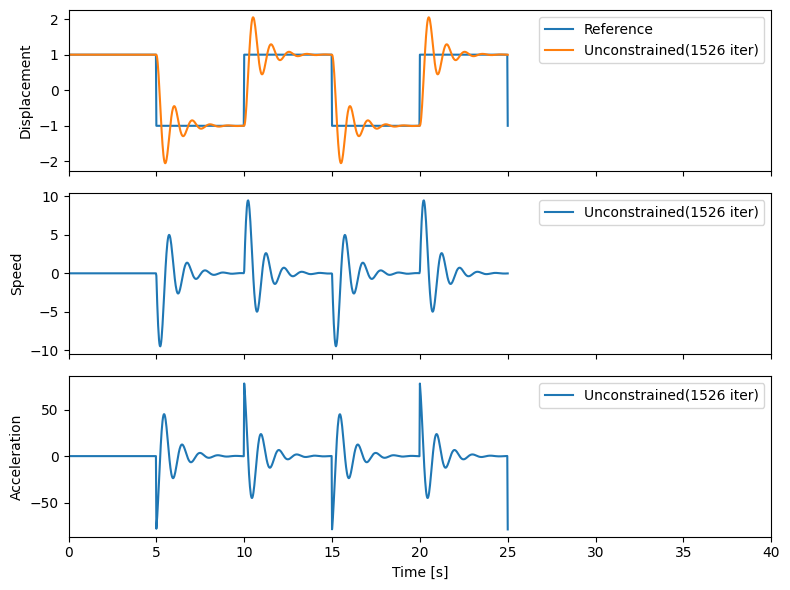

In [18]:
def Unconstrained(x, omega, xi, x_ref, amax, vmax):
    return -omega**2 * (x[0] - x_ref) - 2 * xi * omega * x[1]

plot_solutions([Unconstrained], amax=None,vmax=None)

## Hard limit on the acceleration

We will now add a hard limit on the acceleration. Since this is non-smooth, we expect it to worsen the convergence of the ODE integrator.
The limit is imposed by clipping the acceleration to $\pm a_{\mathrm{max}}$. So that the equation of motion becomes

$$
\ddot{x} = \min(\max(- \omega^2( x - x_{\mathrm{ref}}) - 2 \zeta \omega \dot{x} ), -a_{\mathrm{max}}), +a_{\mathrm{max}})
$$

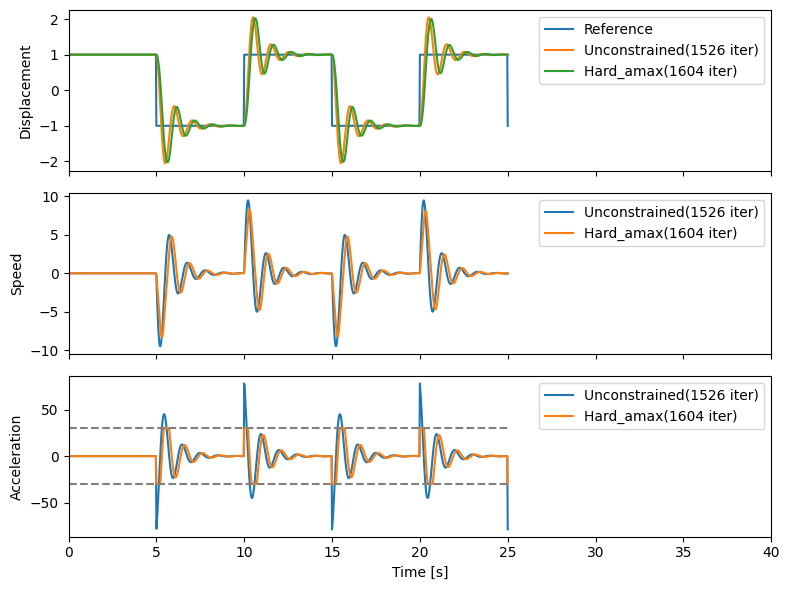

In [19]:
def Hard_amax(x,omega,xi,x_ref,amax,vmax):
    return np.clip(-omega**2 * (x[0] - x_ref) -2 * xi * omega * x[1], -amax, +amax)
plot_solutions([Unconstrained, Hard_amax], amax=30,vmax=None)

## Smooth limit on the acceleration

We will now add a smooth limit on the acceleration. For this we will use $\tanh(x)$, which has unit-slope for small values of x and limits to $\pm 1$
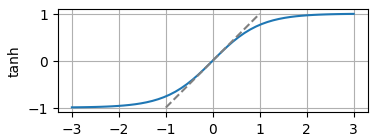

The smooth limit on the acceleration is obtained by
- Scaling the acceleration by the imposed limit.
- Applying the $\tanh$ function.
- Inverse-scaling the acceleration.

$$
\ddot{x} = a_{\mathrm{max}} \tanh\left(\frac{- \omega^2( x - x_{\mathrm{ref}}) - 2 \zeta \omega \dot{x}}{a_{\mathrm{max}}}\right)
$$

When the acceleration is small, and the limit is large, the argument of $\tanh$ is close to 0, and therefore will pass almost unchanged.

In [20]:
def Smooth_amax(x,omega,xi,x_ref,amax,vmax):
    return amax * np.tanh((-omega**2 * (x[0] - x_ref) -2 * xi * omega * x[1]) / amax)

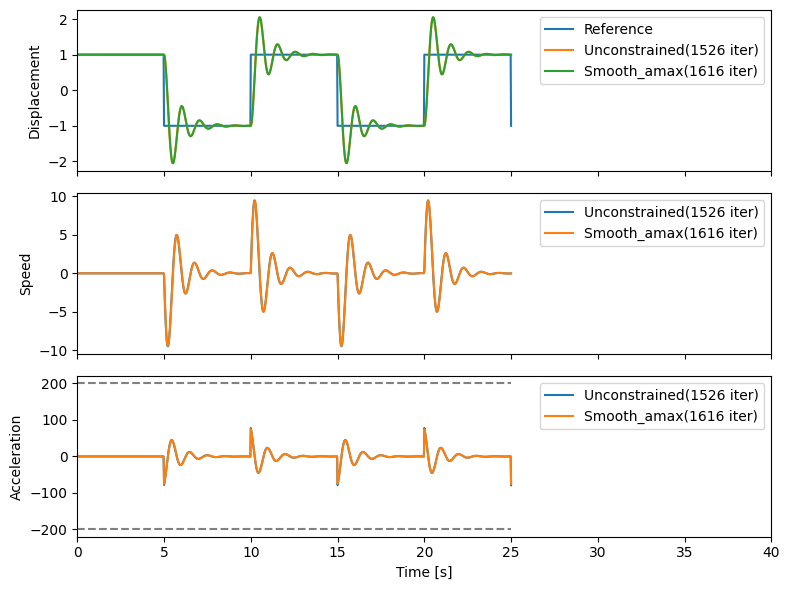

In [21]:
plot_solutions([Unconstrained, Smooth_amax], amax=200,vmax=None)

When the acceleration is larger compared to the limits, the argument of $\tanh$ will be large, and will be clipped to $\pm 1$.

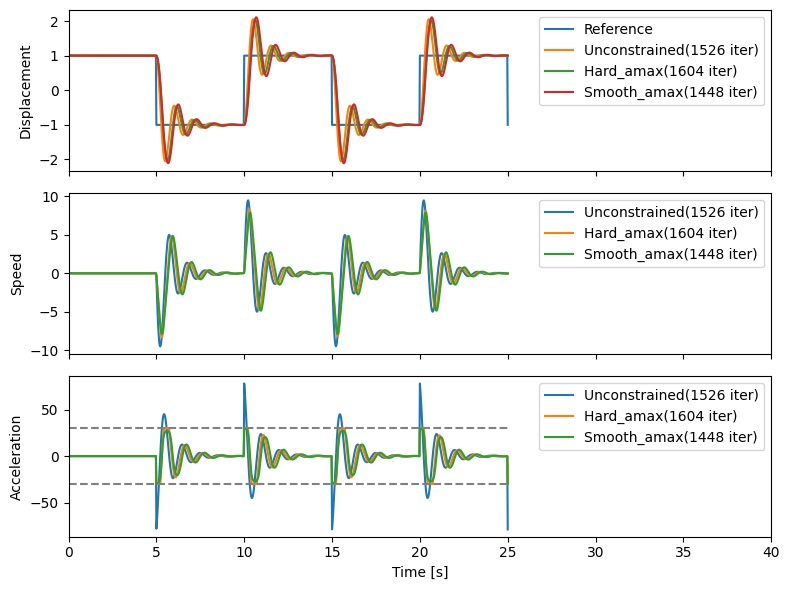

In [22]:
plot_solutions([Unconstrained, Hard_amax, Smooth_amax], amax=30,vmax=None)

## Smooth limit on the acceleration and velocity

Finally we will extend the smooth max to limit both velocity and acceleration by

- Scaling the acceleration by the imposed acceleration and velocity limits.
- Applying the $\tanh$ function.
- Inverse-scaling the acceleration.


$$
\ddot{x} = -\frac{a_{\mathrm{max}}}{v_{\mathrm{max}}}\dot{x} + a_{\mathrm{max}} \tanh\left(\frac{- \omega^2( x - x_{\mathrm{ref}}) - 2 \zeta \omega \dot{x}}{a_{\mathrm{max}}} + \frac{\frac{a_{\mathrm{max}}}{v_{\mathrm{max}}}\dot{x}}{a_{\mathrm{max}}}\right)
$$

$$
\ddot{x} = -\frac{a_{\mathrm{max}}}{v_{\mathrm{max}}}\dot{x} +  a_{\mathrm{max}} \tanh\left(\frac{- \omega^2( x - x_{\mathrm{ref}}) - \left(2 \zeta \omega -  \frac{a_{\mathrm{max}}}{v_{\mathrm{max}}} \right)\dot{x}}{a_{\mathrm{max}}}\right)
$$

In [44]:
def Smooth_avmax(x,omega,xi,x_ref,amax,vmax):
    return - amax / vmax * x[1] + amax * np.tanh( (-omega**2 * (x[0] - x_ref)  - (2 * xi * omega - amax / vmax) * x[1]) / amax)

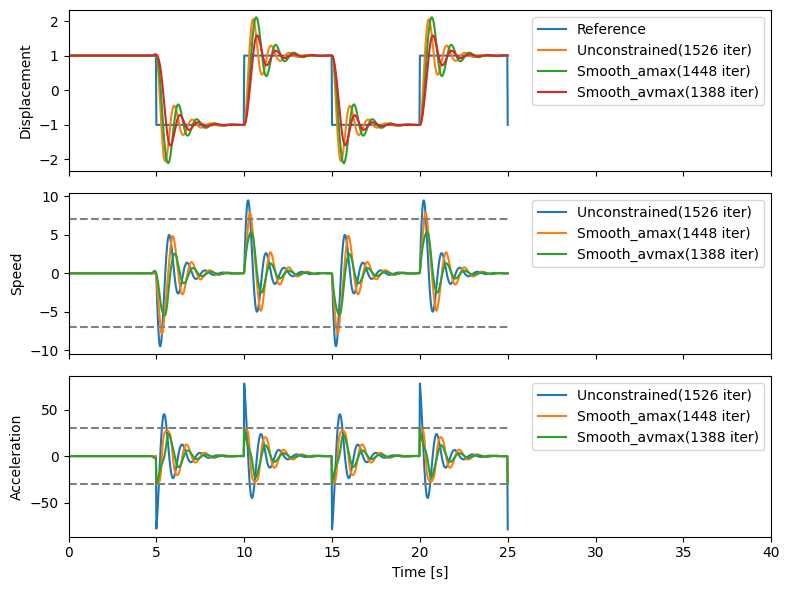

In [43]:
plot_solutions([Unconstrained, Smooth_amax, Smooth_avmax], amax=30,vmax=7)